In [88]:
from ipywidgets import interact
import ipywidgets as widgets
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.io import wavfile
import numpy as np
import seaborn as sns
import os

sns.set_theme()
sns.set_style("darkgrid")

In [89]:
fs, p = wavfile.read('sonido-presion/presion_segmento_1.wav')
fs, b = wavfile.read('sonido-presion/beta_segmento_1.wav')
fs, s_m = wavfile.read('sonido-presion/sonido_segmento_1.wav')
fs, delta = wavfile.read('sonido-presion/delta1_segmento_1.wav')
fs, delta2 = wavfile.read('sonido-presion/delta2_segmento_1.wav')

In [91]:

#funcion del sistema de ecuaciones
def f(X, t, params):
    w, x = X
    k, c, delta, beta = params

    gamma = 1e4*2 #reescaleo
    mu = 1e5

    f_w = -gamma * k / mu * (x + delta / k)
    f_x = gamma * mu * (w - c * x**3 / mu + beta * x / mu )
    return np.array([f_w,f_x])

#método Runge-Kutta 4
def paso_RK(X, f, t, dt, params, orden=4):
    k1 = f(X, t, params)
    k2 = f(X + k1 * dt / 2, t, params)

    if orden == 2:
        X = X + (k1 + k2) / 2 * dt
    elif orden == 4:
        k3 = f(X + k2 * dt / 2, t, params)
        k4 = f(X + k3 * dt, t, params)
        X = X + (k1 + 2 * (k2 + k3) + k4) / 6 * dt
    return X


In [90]:
#preguntar las ci !!!
x0 = 0.01
w0 = 0
X0 = np.array([w0, x0])

#parametros
k, c, f0= 1 , 1, 0

In [92]:
dt_m = 1/fs
N  = len(p)
t_m = np.arange(0, N) * dt_m

print(f'dt muestreo: {dt_m} \n tiempo total de medición {t_m[-1]} s')

dt muestreo: 2.2650056625141562e-05 
 tiempo total de medición 0.8827859569648924 s


In [93]:
#dt = 1/884000
dt = dt_m / 20
t = np.arange(0, t_m[-1] + dt_m, dt)

In [94]:
# la cantidad de puntos que quiero tener:
dt_m/dt * N
print(f'N de la simulacion: {len(t)} \n',f'N de los datos {len(t_m)} \n', f' Tomo de la simulación 1 dato cada {len(t)/len(t_m)}')
len(t)

N de la simulacion: 779520 
 N de los datos 38976 
  Tomo de la simulación 1 dato cada 20.0


779520

In [95]:
#inrepolo p

interp_func = interp1d(t_m, p)

b_interpolado = interp_func(np.linspace(0, t_m[-1],len(t) ))

#interpolo delta
interp_func2 = interp1d(t_m, delta)

delta_interp = interp_func2(np.linspace(0, t_m[-1],len(t) ))

In [96]:
#sumo ruido
sigma_s = np.std(s_m[(p + 0.33)<0]/max(s_m))
ruido = np.random.normal(0, sigma_s, len(t))

N_i = len(t)

#normalizo y offset de beta
offset = 0.3
b_ = (b_interpolado/max(b_interpolado)) + offset 

Xs = np.zeros((N_i + 1, 2))
Xs[0] = X0



In [97]:
# Integración: le agrego el ruido a f0 para 

for j in range(N_i):
    params = [4, c, delta_interp[j] *4 + ruido[j]*5, b_[j]]
    Xs[j + 1] = paso_RK(Xs[j], f, t[j], dt, params, 4)
    

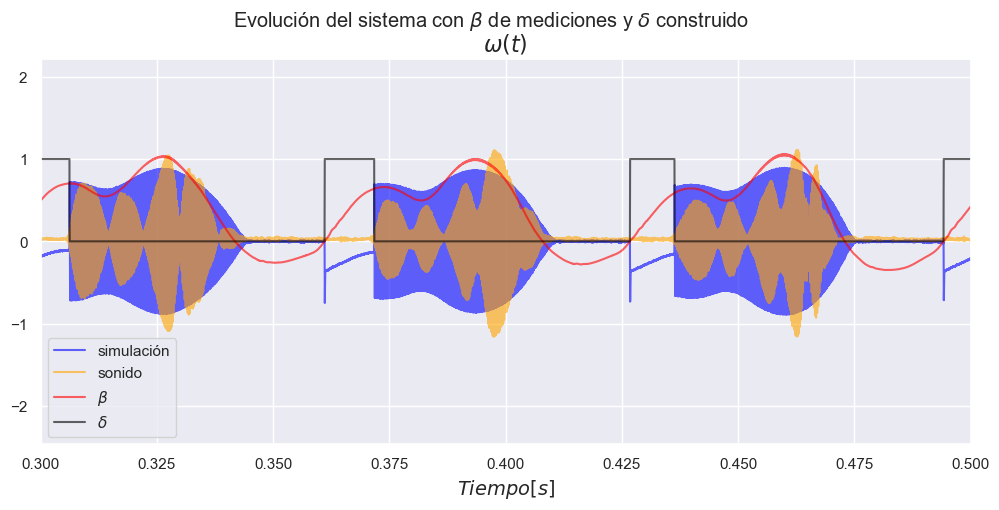

In [98]:
%matplotlib inline
plt.figure( figsize=(12,5))
#ploteo
colors = ['green','red','black','blue']
plt.plot(t,Xs[:,0][:-1] / max(Xs[:,0]),alpha = .60, color=colors[3], label = r'simulación')
plt.plot(t_m,s_m/max(s_m) * 2,alpha = .60, color='orange', label = r'sonido')
plt.plot(t,b_,alpha = .60, color=colors[1], label = r'$\beta$')
plt.plot(t,delta_interp,alpha = .60, color=colors[2], label = r'$\delta$')
plt.legend(loc=0)
plt.xlim(0.3,0.5)
plt.xlabel('$Tiempo [s]$', fontsize=14)
plt.title(r'$\omega(t)$', fontsize=16)


plt.suptitle(r"Evolución del sistema con $\beta$ de mediciones y $\delta$ construido")
plt.show()

In [34]:
wavfile.write("sonido-presion/simulacion_segmento_1.wav", fs, Xs[:,0][:-1].astype(np.float32))

In [113]:
np.sqrt(1 + 9/16)

np.float64(1.25)

### Espectrograma

In [100]:
def get_spectrogram(data, sampling_rate, window=1024, overlap=1/1.1,
                    sigma=102.4, fmax=8000, drange=6):
    fu, tu, Sxx = signal.spectrogram(data, sampling_rate, nperseg=window,
                                     noverlap=window*overlap,
                                     window=signal.get_window
                                     (('gaussian', sigma), window),
                                     scaling='spectrum')
    Sxx = np.clip(Sxx, a_min=np.amax(Sxx)/10**drange, a_max=np.amax(Sxx))
    return fu, tu, Sxx

In [99]:
import matplotlib.colors as mcolors
colors = [(1,0,0,c) for c in np.linspace(0,1,100)]
cmapred = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=5)


#### Varío k

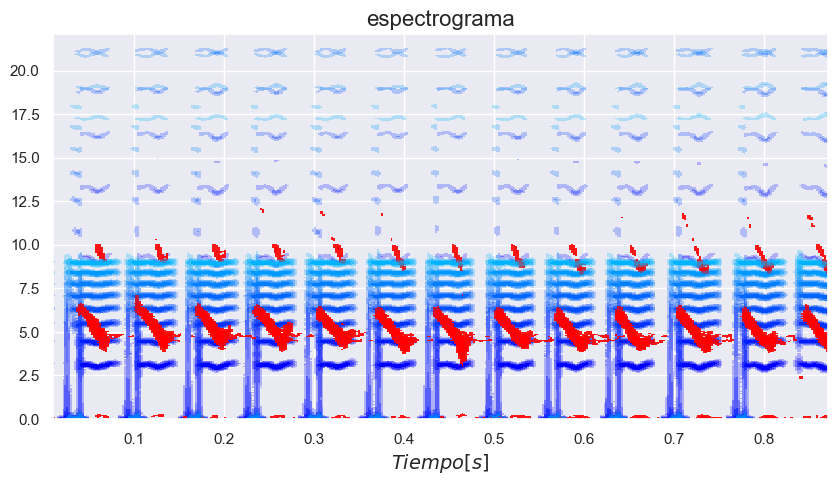

In [101]:
#espectrograma sonido de mediciones
fu, tu, Sxx = get_spectrogram(s_m, 44150)
Sxx = np.clip(Sxx, a_min=np.amax(Sxx)/20000000, a_max = np.amax(Sxx))



ks = np.linspace(1,8,8)


plt.figure( figsize=(10,5))

for i,k in enumerate(ks):
    
    #condiciones iniciales 
    Xs = np.zeros((N_i + 1, 2))
    Xs[0] = X0
    #integro
    for j in range(N_i):
        params = [k, c, delta_interp[j]  + ruido[j], b_[j]]
        Xs[j + 1] = paso_RK(Xs[j], f, t[j], dt, params, 4)

    #espextrograma simulacion
    fu_s, tu_s, Sxx_s = get_spectrogram(Xs[:,0][::20], 44150)
    Sxx_s = np.clip(Sxx_s, a_min=np.amax(Sxx_s)/20000000, a_max = np.amax(Sxx_s))

    #colormap
    colors = [(0,0.1 * i,1,c) for c in np.linspace(0,1,100)]
    cmapblue = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=5)
    colors = ['green','red','black','blue']


    #ploteo espectrograma
    plt.pcolormesh(tu_s, fu_s/1000, np.log(Sxx_s), rasterized=True, shading='auto', cmap=cmapblue)
    plt.pcolormesh(tu, fu/1000, np.log(Sxx), rasterized=True, shading='auto', cmap=cmapred)
    plt.xlabel('$Tiempo [s]$', fontsize=14)
    plt.title(r'espectrograma', fontsize=16)
plt.show()



In [102]:
import json
file_fonacion = open('sonido-presion/t_fon_segmento_1.json')
file_silabas = open('sonido-presion/t_silabas.json')

# returns JSON object as a list 
t_silabas = json.load(file_silabas)['segmento_1']
t_fonacion= json.load(file_fonacion) 

Habría que aumentar delta a medida que aumento k para matar las oscilaciones


In [103]:
k = np.ones(N_i)
f0 = np.ones(N_i)
for i,sil in enumerate(t_silabas):
    ti = t_silabas[sil]['t_i']
    tf = t_silabas[sil]['t_f']

    #index
    index_i = np.where(t >= ti)[0][0]
    index_f = np.where(t >= tf)[0][0]

    ks_new =  np.flip(np.linspace(1.5,4.5,int(index_f - index_i)))
    f0_new = 5
    
    k[index_i : index_f] = ks_new
    f0[index_i : index_f] = f0_new

In [104]:
k_ = k
#condiciones iniciales 
Xs = np.zeros((N_i + 1, 2))
Xs[0] = X0
#integro
for j in range(N_i):
    params = [k_[j], c, (delta_interp[j]  + ruido[j]) * f0[j], b_[j]]
    Xs[j + 1] = paso_RK(Xs[j], f, t[j], dt, params, 4)

#espextrograma simulacion
fu_s, tu_s, Sxx_s = get_spectrogram(Xs[:,0][::20], 44150)
Sxx_s = np.clip(Sxx_s, a_min=np.amax(Sxx_s)/20000000, a_max = np.amax(Sxx_s))

#colormap
colors = [(0,0.1 * i,1,c) for c in np.linspace(0,1,100)]
cmapblue = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=5)
colors = ['green','red','black','blue']



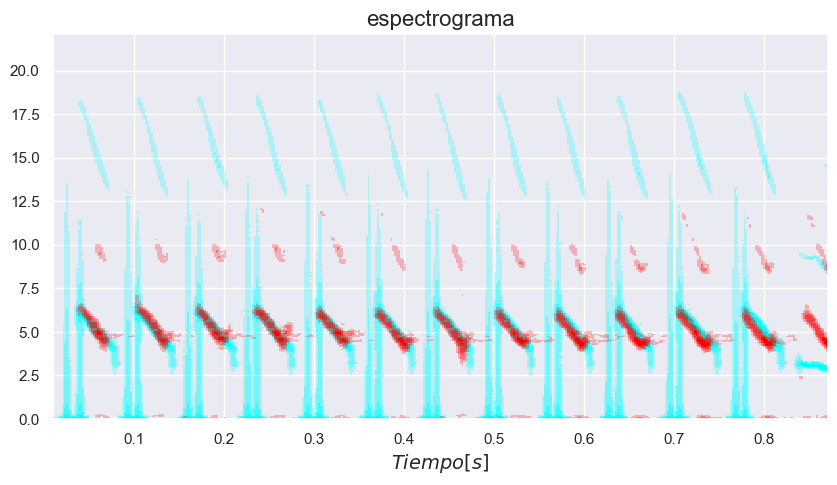

In [105]:

#ploteo espectrograma
plt.figure(figsize = (10,5))
plt.pcolormesh(tu_s, fu_s/1000, np.log(Sxx_s), rasterized=True, shading='auto', cmap=cmapblue, label = 'simulacion')
plt.pcolormesh(tu, fu/1000, np.log(Sxx), rasterized=True, shading='auto', cmap=cmapred, label = 'sonido')

plt.xlabel('$Tiempo [s]$', fontsize=14)
plt.title(r'espectrograma', fontsize=16)

plt.show()

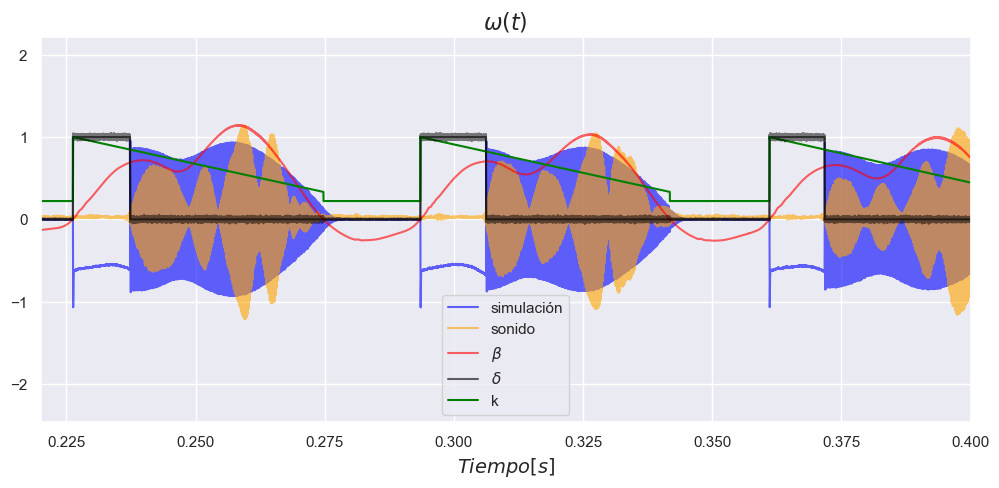

In [106]:
%matplotlib inline
plt.figure( figsize=(12,5))
#ploteo
colors = ['green','red','black','blue']
plt.plot(t,Xs[:,0][:-1] / max(Xs[:,0]),alpha = .60, color=colors[3], label = r'simulación')
plt.plot(t_m,s_m/max(s_m) * 2,alpha = .60, color='orange', label = r'sonido')
plt.plot(t,b_,alpha = .60, color=colors[1], label = r'$\beta$')
plt.plot(t,delta_interp,alpha = .60, color=colors[2], label = r'$\delta$')
plt.plot(t, k_/max(k_), color = 'green', label = 'k')
plt.plot(t,( (delta_interp  + ruido) * f0)/5, color = 'black', alpha = .5)
#plt.plot(t, (delta_interp  + ruido) * f0, alpha = .6, color = colors[2], label = r'$\delta$')
plt.legend(loc=0)
plt.xlim(0.22,0.4)
plt.xlabel('$Tiempo [s]$', fontsize=14)
plt.title(r'$\omega(t)$', fontsize=16)
plt.show()

In [107]:
def y(w,x, beta):
    mu = 1e5
    return w - mu * (x**3/3 - beta * x )

779521 779521 779520


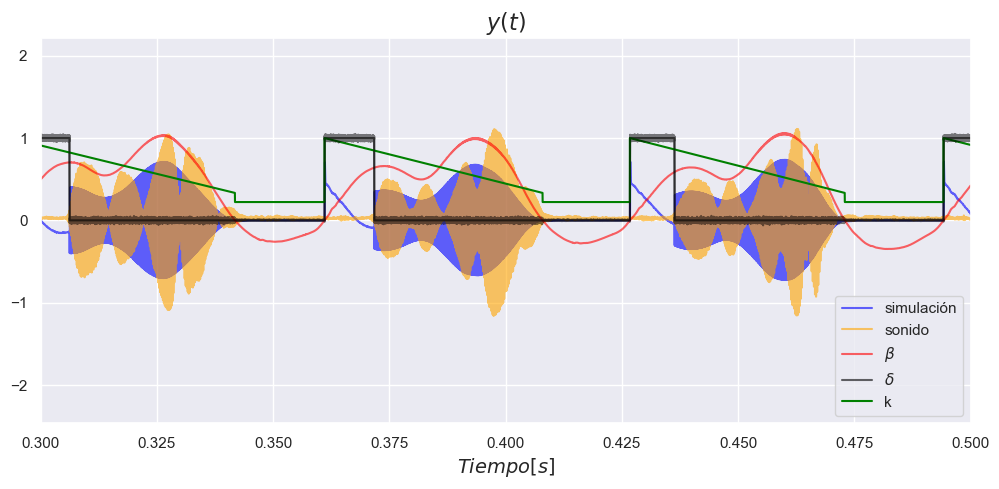

In [108]:
%matplotlib inline
plt.figure( figsize=(12,5))
#ploteo
colors = ['green','red','black','blue']
print(len(Xs[:,0]),len(Xs[:,1]), len(b_))
y_ = y(Xs[:,0][:-1],Xs[:,1][:-1], b_)
plt.plot(t,y_/max(y_),alpha = .60, color=colors[3], label = r'simulación')
plt.plot(t_m,s_m/max(s_m) * 2,alpha = .60, color='orange', label = r'sonido')
plt.plot(t,b_,alpha = .60, color=colors[1], label = r'$\beta$')
plt.plot(t,delta_interp,alpha = .60, color=colors[2], label = r'$\delta$')
plt.plot(t, k_/max(k_), color = 'green', label = 'k')
plt.plot(t,( (delta_interp  + ruido) * f0)/5, color = 'black', alpha = .5)
#plt.plot(t, (delta_interp  + ruido) * f0, alpha = .6, color = colors[2], label = r'$\delta$')
plt.legend(loc=0)
plt.xlim(0.3,0.5)
plt.xlabel('$Tiempo [s]$', fontsize=14)
plt.title(r'$y(t)$', fontsize=16)
plt.show()

In [109]:
wavfile.write("sonido-presion/y_segmento_1.wav", fs, y_[::20].astype(np.float32))
wavfile.write("sonido-presion/k_segmento_1.wav", fs, k_[::20].astype(np.float32))

#### Varío $\delta$

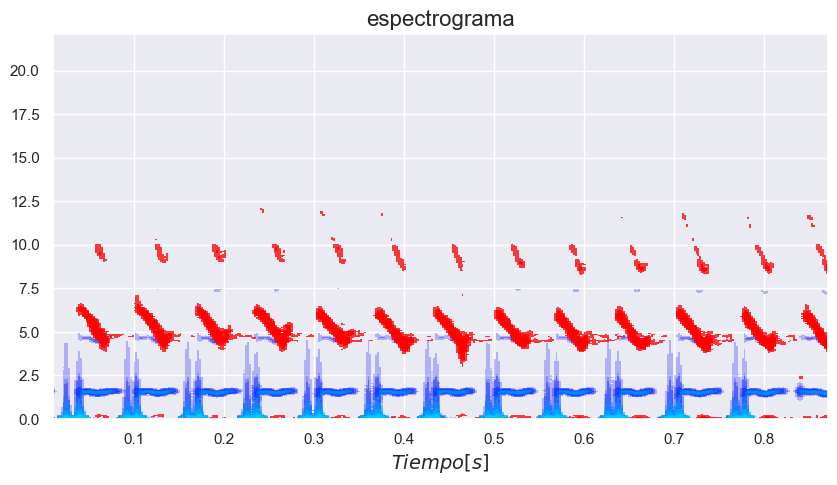

In [57]:

deltas = np.linspace(1,5,5)


plt.figure( figsize=(10,5))

for i,d in enumerate(deltas):
    
    #condiciones iniciales 
    Xs = np.zeros((N_i + 1, 2))
    Xs[0] = X0
    #integro
    for j in range(N_i):
        params = [1, c, (delta_interp[j]  + ruido[j]) * d, b_[j]]
        Xs[j + 1] = paso_RK(Xs[j], f, t[j], dt, params, 4)

    #espextrograma simulacion
    fu_s, tu_s, Sxx_s = get_spectrogram(Xs[:,0][::20], 44150)
    Sxx_s = np.clip(Sxx_s, a_min=np.amax(Sxx_s)/20000000, a_max = np.amax(Sxx_s))

    #colormap
    colors = [(0,0.2 * i,1,c) for c in np.linspace(0,1,100)]
    cmapblue = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=5)
    colors = ['green','red','black','blue']


    #ploteo espectrograma
    plt.pcolormesh(tu_s, fu_s/1000, np.log(Sxx_s), rasterized=True, shading='auto', cmap=cmapblue)
    plt.pcolormesh(tu, fu/1000, np.log(Sxx), rasterized=True, shading='auto', cmap=cmapred)
    plt.xlabel('$Tiempo [s]$', fontsize=14)
    plt.title(r'espectrograma', fontsize=16)
plt.show()



#### Varío c

In [59]:
np.linspace(-1,5,7)

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.])

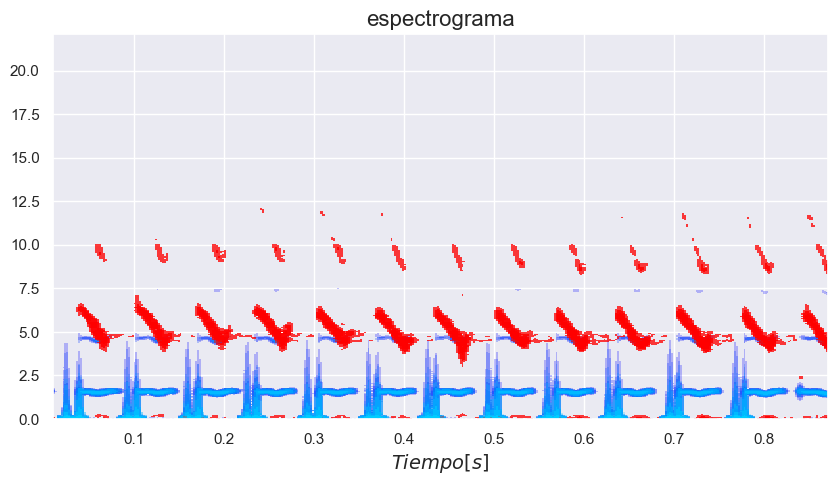

In [61]:

cs = np.linspace(1,5,5)


plt.figure( figsize=(10,5))

for i,c in enumerate(cs):
    
    #condiciones iniciales 
    Xs = np.zeros((N_i + 1, 2))
    Xs[0] = X0
    #integro
    for j in range(N_i):
        params = [1, c, delta_interp[j]  + ruido[j], b_[j]]
        Xs[j + 1] = paso_RK(Xs[j], f, t[j], dt, params, 4)

    #espextrograma simulacion
    fu_s, tu_s, Sxx_s = get_spectrogram(Xs[:,0][::20], 44150)
    Sxx_s = np.clip(Sxx_s, a_min=np.amax(Sxx_s)/20000000, a_max = np.amax(Sxx_s))

    #colormap
    colors = [(0,0.2 * i,1,c) for c in np.linspace(0,1,100)]
    cmapblue = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=5)
    colors = ['green','red','black','blue']


    #ploteo espectrograma
    plt.pcolormesh(tu_s, fu_s/1000, np.log(Sxx_s), rasterized=True, shading='auto', cmap=cmapblue)
    plt.pcolormesh(tu, fu/1000, np.log(Sxx), rasterized=True, shading='auto', cmap=cmapred)
    plt.xlabel('$Tiempo [s]$', fontsize=14)
    plt.title(r'espectrograma', fontsize=16)
plt.show()

